# **Enviroment Preparation**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Scikit-Learn Imports ---
# For TF-IDF (DNN model)
from sklearn.feature_extraction.text import TfidfVectorizer
# For evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

# --- TensorFlow/Keras Imports ---
# For Tokenization (RNN/LSTM models)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# For Building Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

print("All libraries imported.")

2025-11-21 09:09:35.373059: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-21 09:09:35.373310: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 09:09:35.413234: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All libraries imported.


2025-11-21 09:09:36.296894: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-21 09:09:36.297174: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
train_output_path = '../data/processed/train_data.csv'
test_output_path = '../data/processed/test_data.csv'

train_df = pd.read_csv(train_output_path)
test_df = pd.read_csv(test_output_path)

In [4]:
# Prepare data and handle potential NaNs (from empty sentences)
X_train = train_df['processed_sentence'].fillna('')
y_train = train_df['sentiment']

X_test = test_df['processed_sentence'].fillna('')
y_test = test_df['sentiment']

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print("\n--- Training Data Example ---")
print(X_train.head())

Training samples: 2180
Test samples: 546

--- Training Data Example ---
0       dont trust website dont expect helpful support
1               film terrible credit version watchable
2          really recommend place go wrong donut place
3    memory murky say enjoy every single episode pr...
4       headset work great package nicely avoid damage
Name: processed_sentence, dtype: object


# **Dense Neural Network (DNN)**

## **Vectorization (TF-IDF)**

In [5]:
# We will use TF-IDF to convert the text into numerical vectors
# for our Dense network.

print("Initializing and fitting TF-IDF Vectorizer...")

# Initialize the vectorizer
# max_features limits the vocabulary to the top 5000 words
vectorizer = TfidfVectorizer(max_features=5000)

# 1. Fit the vectorizer ONLY on the training data
vectorizer.fit(X_train)

# 2. Transform both the training and test data
X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Convert from sparse matrix to dense array for Keras
X_train_tfidf = X_train_tfidf.toarray()
X_test_tfidf = X_test_tfidf.toarray()

# Get the vocabulary size (this is our input dimension)
vocab_size = X_train_tfidf.shape[1]

print(f"TF-IDF vectorization complete.")
print(f"Vocabulary size: {vocab_size}")
print(f"Training data shape: {X_train_tfidf.shape}")
print(f"Test data shape: {X_test_tfidf.shape}")

Initializing and fitting TF-IDF Vectorizer...
TF-IDF vectorization complete.
Vocabulary size: 3571
Training data shape: (2180, 3571)
Test data shape: (546, 3571)


## **Building the DNN Model**

In [6]:
# We'll use a simple Sequential model
dnn_model = Sequential()

# Input Layer
# The input_dim must match our vocabulary size from TF-IDF
dnn_model.add(Dense(64, activation='relu', input_dim=vocab_size))
dnn_model.add(Dropout(0.5)) # Dropout helps prevent overfitting

# Hidden Layer
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dropout(0.5))

# Output Layer
# We use 1 neuron with 'sigmoid' activation for binary (0 or 1) classification
dnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
dnn_model.compile(
    loss='binary_crossentropy', # Best loss function for binary classification
    optimizer='adam',           # A standard, effective optimizer
    metrics=['accuracy']        # We want to track accuracy
)

# Print a summary of the model's architecture
dnn_model.summary()

c:\Users\joshe\Desktop\TI2CED3\IntegrativeTaskII-Nieto_Urbina_Velez\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │       228,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,721 (901.25 KB)

 Trainable params: 230,721 (901.25 KB)

 Non-trainable params: 0 (0.00 B)

## **Train the Model**

In [7]:
print("Training the DNN model...")

# We use EarlyStopping to stop training once the model
# isn't improving, which helps prevent overfitting.
early_stop = EarlyStopping(
    monitor='val_loss', # Watch the validation loss
    patience=3,         # Stop after 3 epochs of no improvement
    restore_best_weights=True # Go back to the best version of the model
)

# We use 20% of our training data as a 'validation' set
# to monitor for overfitting
history = dnn_model.fit(
    X_train_tfidf,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2, # Use 20% of training data for validation
    callbacks=[early_stop]
)

print("Model training complete.")

Training the DNN model...


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5505 - loss: 0.6911 - val_accuracy: 0.6743 - val_loss: 0.6877
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6525 - loss: 0.6738 - val_accuracy: 0.7179 - val_loss: 0.6571
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7787 - loss: 0.5959 - val_accuracy: 0.7638 - val_loss: 0.5580
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8526 - loss: 0.4418 - val_accuracy: 0.7936 - val_loss: 0.4582
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9140 - loss: 0.2896 - val_accuracy: 0.7913 - val_loss: 0.4357
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9484 - loss: 0.1916 - val_accuracy: 0.7844 - val_loss: 0.4406
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9639 - loss: 0.1412 - val_accuracy: 0.7775 - val_loss: 0.4596
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9708 - loss: 0.1079 - val_accuracy: 0.7775 - val_loss:

## **Evaluate the DNN Model**

In [8]:
# Evaluate the model on the test set
loss, accuracy = dnn_model.evaluate(X_test_tfidf, y_test, verbose=0)

print("\n--- DNN Model Evaluation (Test Set) ---")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss:     {loss:.4f}")

# Get detailed predictions
# We must round the sigmoid output (e.g., 0.8 -> 1, 0.3 -> 0)
y_pred_probs = dnn_model.predict(X_test_tfidf)
y_pred = (y_pred_probs > 0.5).astype(int)

# Print a full classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Negative (0)', 'Positive (1)']))

# Compare to baseline
print(f"\nBaseline Accuracy was: 0.5220")
print(f"DNN Accuracy is:     {accuracy:.4f}")


--- DNN Model Evaluation (Test Set) ---
Test Accuracy: 0.8168
Test Loss:     0.4180
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

--- Classification Report ---
              precision    recall  f1-score   support

Negative (0)       0.79      0.86      0.82       271
Positive (1)       0.85      0.78      0.81       275

    accuracy                           0.82       546
   macro avg       0.82      0.82      0.82       546
weighted avg       0.82      0.82      0.82       546


Baseline Accuracy was: 0.5220
DNN Accuracy is:     0.8168


## **Tuning DNN**

### Create a Model-Building Function

In [9]:
# We need the input dimension from our TF-IDF vectors
# This must be defined before the function
try:
    input_dim = X_train_tfidf.shape[1]
    print(f"Input dimension set to: {input_dim}")
except NameError:
    print("Error: 'X_train_tfidf' is not defined.")
    print("Please run the TF-IDF vectorization cell first.")

def create_dnn_model(hidden_units=64, dropout_rate=0.5, optimizer='adam'):
    """
    Builds and compiles a Keras DNN model.
    This function will be called by GridSearchCV.
    """
    model = Sequential()

    # Input Layer (with tunable parameters)
    model.add(Dense(hidden_units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))

    # Hidden Layer (we'll keep this one fixed for the example)
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )
    return model

Input dimension set to: 3571


### **Define the Parameter Grid**

In [10]:
# 1. Wrap the model builder using KerasClassifier
# We pass any parameters here that we are NOT tuning in the grid
keras_model = KerasClassifier(
    model=create_dnn_model,
    verbose=0 # Suppresses epoch logging during grid search
)

# 2. Define the grid of parameters to test
# WARNING: A large grid can take a very long time to run.
# This is a small, example grid for speed.
param_grid = {
    'batch_size': [32, 64],
    'epochs': [10, 20],
    'model__hidden_units': [32, 64],
    'model__dropout_rate': [0.3, 0.5],
    'model__optimizer': ['adam', 'rmsprop']
}

print("Parameter grid defined:")
print(param_grid)

Parameter grid defined:
{'batch_size': [32, 64], 'epochs': [10, 20], 'model__hidden_units': [32, 64], 'model__dropout_rate': [0.3, 0.5], 'model__optimizer': ['adam', 'rmsprop']}


### Run the Grid Search

In [11]:
# Initialize GridSearchCV
# cv=3 -> 3-fold cross-validation
# n_jobs=-1 -> Use all available CPU cores
grid_search = GridSearchCV(
    estimator=keras_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2 # Show progress
)

print("Starting Grid Search... (This may take a while)")

# Fit the grid search to the training data
grid_search.fit(X_train_tfidf, y_train)

print("Grid Search complete.")

Starting Grid Search... (This may take a while)
Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\joshe\Desktop\TI2CED3\IntegrativeTaskII-Nieto_Urbina_Velez\venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Grid Search complete.


### Review Tuning Results and Evaluate

In [12]:
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")
print("\nBest Parameters found:")
print(grid_search.best_params_)

# 'grid_search.best_estimator_' is the final model,
# retrained on the *entire* training set using the best parameters.
best_dnn_model = grid_search.best_estimator_

# --- Final Evaluation on the Test Set ---
print("\nEvaluating the tuned model on the TEST set...")
y_pred_tuned = best_dnn_model.predict(X_test_tfidf)

# Get the new accuracy
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

print(f"\nOriginal DNN Accuracy: 0.8095")
print(f"Tuned DNN Accuracy:    {accuracy_tuned:.4f}")

# Print a full classification report
print("\n--- Tuned Model Classification Report ---")
print(classification_report(y_test, y_pred_tuned, target_names=['Negative (0)', 'Positive (1)']))

Best Cross-Validation Accuracy: 0.8018

Best Parameters found:
{'batch_size': 32, 'epochs': 10, 'model__dropout_rate': 0.3, 'model__hidden_units': 64, 'model__optimizer': 'rmsprop'}

Evaluating the tuned model on the TEST set...

Original DNN Accuracy: 0.8095
Tuned DNN Accuracy:    0.8187

--- Tuned Model Classification Report ---
              precision    recall  f1-score   support

Negative (0)       0.84      0.78      0.81       271
Positive (1)       0.80      0.86      0.83       275

    accuracy                           0.82       546
   macro avg       0.82      0.82      0.82       546
weighted avg       0.82      0.82      0.82       546



# **Long short-term memory Neural Network (LSTM)**

## **Text Tokenization and Padding**

In [13]:
# For LSTM models, we need to convert text into sequences of integers
# and then pad them to ensure uniform length.

print("Initializing tokenizer for LSTM...")

# Initialize the tokenizer with a vocabulary size limit
# Using 4000 words to balance between coverage and overfitting prevention
vocab_size_lstm = 4000

tokenizer = Tokenizer(num_words=vocab_size_lstm, oov_token='<OOV>')

# Fit the tokenizer ONLY on training data
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Calculate max sequence length using 95th percentile (anti-overfitting measure)
# This prevents outliers from forcing unnecessary padding
sequence_lengths = [len(seq) for seq in X_train_seq]
max_length = int(np.percentile(sequence_lengths, 95))

print(f"\nSequence Length Statistics:")
print(f"  Min length: {np.min(sequence_lengths)}")
print(f"  Max length: {np.max(sequence_lengths)}")
print(f"  Mean length: {np.mean(sequence_lengths):.2f}")
print(f"  95th percentile: {max_length}")

# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Print tokenization results
actual_vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
print(f"\nTokenization Complete!")
print(f"  Vocabulary size (actual): {actual_vocab_size}")
print(f"  Vocabulary size (used): {min(actual_vocab_size, vocab_size_lstm)}")
print(f"  Max sequence length: {max_length}")
print(f"  Training data shape: {X_train_padded.shape}")
print(f"  Test data shape: {X_test_padded.shape}")

Initializing tokenizer for LSTM...

Sequence Length Statistics:
  Min length: 0
  Max length: 41
  Mean length: 6.12
  95th percentile: 14

Tokenization Complete!
  Vocabulary size (actual): 3576
  Vocabulary size (used): 3576
  Max sequence length: 14
  Training data shape: (2180, 14)
  Test data shape: (546, 14)


## **Building the LSTM Model**

In [14]:
def create_lstm_model(vocab_size, embedding_dim=50, lstm_units=64, dropout_rate=0.5, optimizer='adam'):
    """
    Creates a simple LSTM model for sentiment classification.
    
    ANTI-OVERFITTING MEASURES:
    - Small embedding dimension (50)
    - Single LSTM layer (avoids deep architecture overfitting)
    - Aggressive dropout (0.5 default)
    - SpatialDropout1D for embeddings
    - L2 regularization on Dense layer
    
    Parameters:
    -----------
    vocab_size : int
        Size of the vocabulary
    embedding_dim : int
        Dimension of word embeddings (default: 50)
    lstm_units : int
        Number of LSTM units (default: 64)
    dropout_rate : float
        Dropout rate (default: 0.5)
    optimizer : str
        Optimizer to use (default: 'adam')
    
    Returns:
    --------
    model : Sequential
        Compiled LSTM model
    """
    import tensorflow as tf
    
    model = Sequential([
        # Embedding layer - learns word representations
        Embedding(input_dim=vocab_size, 
                  output_dim=embedding_dim, 
                  input_length=max_length,
                  name='embedding_layer'),
        
        # Spatial dropout for embeddings (more effective than regular dropout)
        SpatialDropout1D(dropout_rate * 0.4, name='spatial_dropout'),
        
        # Single LSTM layer - AVOID stacking multiple LSTMs (causes overfitting)
        LSTM(units=lstm_units, 
             dropout=dropout_rate * 0.4,              # Recurrent dropout
             recurrent_dropout=dropout_rate * 0.3,    # Additional recurrent dropout
             name='lstm_layer'),
        
        # Regular dropout before dense layer
        Dropout(dropout_rate, name='dropout'),
        
        # Output layer with L2 regularization
        Dense(1, activation='sigmoid', 
              kernel_regularizer=tf.keras.regularizers.l2(0.001),
              name='output_layer')
    ])
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create a sample model to visualize architecture
print("Building LSTM Model Architecture...\n")
sample_lstm_model = create_lstm_model(
    vocab_size=min(actual_vocab_size, vocab_size_lstm), 
    embedding_dim=50, 
    lstm_units=64
)

# Build the model explicitly with input shape to show parameters
sample_lstm_model.build(input_shape=(None, max_length))

print(sample_lstm_model.summary())
print("\nLSTM model architecture defined!")

Building LSTM Model Architecture...



c:\Users\joshe\Desktop\TI2CED3\IntegrativeTaskII-Nieto_Urbina_Velez\venv\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 14, 50)         │       178,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout                 │ (None, 14, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer (LSTM)               │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,305 (813.69 KB)

 Trainable params: 208,305 (813.69 KB)

 Non-trainable params: 0 (0.00 B)

None

LSTM model architecture defined!


## **Hyperparameter Tuning with GridSearchCV**

In [15]:
# Store parameters as constants to avoid serialization issues
LSTM_VOCAB_SIZE = min(actual_vocab_size, vocab_size_lstm)
LSTM_MAX_LENGTH = max_length

# Wrap the model for sklearn compatibility
def create_model_wrapper(embedding_dim=50, lstm_units=64, dropout_rate=0.5, optimizer='adam'):
    """
    Wrapper function for KerasClassifier.
    Uses module-level constants to avoid serialization issues with multiprocessing.
    """
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout, Input
    
    model = Sequential()
    
    # Add Input layer explicitly to ensure model is properly built
    model.add(Input(shape=(LSTM_MAX_LENGTH,)))
    
    # Embedding layer - learns word representations
    model.add(Embedding(input_dim=LSTM_VOCAB_SIZE, 
                        output_dim=embedding_dim))
    
    # Spatial dropout for embeddings (more effective than regular dropout)
    model.add(SpatialDropout1D(dropout_rate * 0.4))
    
    # Single LSTM layer - AVOID stacking multiple LSTMs (causes overfitting)
    model.add(LSTM(units=lstm_units, 
                   dropout=dropout_rate * 0.4,              # Recurrent dropout
                   recurrent_dropout=dropout_rate * 0.3))   # Additional recurrent dropout
    
    # Regular dropout before dense layer
    model.add(Dropout(dropout_rate))
    
    # Output layer with L2 regularization
    model.add(Dense(1, activation='sigmoid', 
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create KerasClassifier wrapper
keras_lstm_model = KerasClassifier(
    model=create_model_wrapper,
    embedding_dim=50,
    lstm_units=64,
    dropout_rate=0.5,
    optimizer='adam',
    epochs=10,
    batch_size=32,
    verbose=0
)

# MINIMAL parameter grid - quality over quantity
# This grid focuses on the most impactful parameters while keeping combinations manageable
param_grid = {
    'batch_size': [32, 64],                        # 2 values - batch size affects convergence
    'epochs': [15, 20],                            # 2 values - training duration
    'model__embedding_dim': [50],                  # 1 value - keep fixed (50 is optimal)
    'model__lstm_units': [64, 96],                 # 2 values - small sizes only to prevent overfitting
    'model__dropout_rate': [0.4, 0.5],             # 2 values - aggressive dropout
    'model__optimizer': ['adam']                    # 1 value - adam is best for this task
}

# Calculate total combinations
total_combinations = np.prod([len(v) for v in param_grid.values()])

print("="*60)
print("HYPERPARAMETER TUNING SETUP")
print("="*60)
print("\nParameter grid:")
for key, value in param_grid.items():
    print(f"  {key:.<30} {value}")
print(f"\nTotal combinations to test: {total_combinations}")
print(f"Cross-validation folds: 3")
print(f"Total model trainings: {total_combinations * 3}")
print(f"\nEstimated time: 15-30 minutes (depending on hardware)")
print("="*60)

HYPERPARAMETER TUNING SETUP

Parameter grid:
  batch_size.................... [32, 64]
  epochs........................ [15, 20]
  model__embedding_dim.......... [50]
  model__lstm_units............. [64, 96]
  model__dropout_rate........... [0.4, 0.5]
  model__optimizer.............. ['adam']

Total combinations to test: 16
Cross-validation folds: 3
Total model trainings: 48

Estimated time: 15-30 minutes (depending on hardware)


In [16]:
# Initialize GridSearchCV
# NOTE: Using n_jobs=1 to avoid multiprocessing serialization issues with Keras models
grid_search_lstm = GridSearchCV(
    estimator=keras_lstm_model,
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=1,                # Sequential execution (avoids serialization issues)
    verbose=2,               # Show progress
    return_train_score=True  # Track training scores to detect overfitting
)

print("\nStarting Grid Search for LSTM...")
print("Using 3-fold cross-validation with aggressive regularization...")
print("NOTE: Running sequentially (n_jobs=1) to avoid serialization issues.")
print("This will take some time. Please be patient.\n")

# Fit the grid search
import time
start_time = time.time()

grid_search_lstm.fit(X_train_padded, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print("\n" + "="*60)
print("Grid Search complete!")
print(f"Time elapsed: {elapsed_time/60:.2f} minutes")
print("="*60)


Starting Grid Search for LSTM...
Using 3-fold cross-validation with aggressive regularization...
NOTE: Running sequentially (n_jobs=1) to avoid serialization issues.
This will take some time. Please be patient.

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.4, model__embedding_dim=50, model__lstm_units=64, model__optimizer=adam; total time=  10.8s
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.4, model__embedding_dim=50, model__lstm_units=64, model__optimizer=adam; total time=  10.6s
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.4, model__embedding_dim=50, model__lstm_units=64, model__optimizer=adam; total time=  10.6s
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.4, model__embedding_dim=50, model__lstm_units=96, model__optimizer=adam; total time=  11.4s
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.4, model__embedding_dim=50, model__lstm_units=96, model__optimizer=adam; 

### Review Tuning Results and Evaluate

In [17]:
# Display best parameters and CV score
print("="*60)
print("GRID SEARCH RESULTS")
print("="*60)
print(f"\nBest Cross-Validation Accuracy: {grid_search_lstm.best_score_:.4f}")
print("\nBest Parameters found:")
for param, value in grid_search_lstm.best_params_.items():
    print(f"  {param:.<35} {value}")

# Analyze CV results to check for overfitting
cv_results = pd.DataFrame(grid_search_lstm.cv_results_)
cv_results_sorted = cv_results.sort_values('rank_test_score')

print("\n" + "="*60)
print("TOP 5 PARAMETER COMBINATIONS")
print("="*60)
print("\nRank | Test Score | Train Score | Std Dev | Parameters")
print("-" * 90)

for i, idx in enumerate(cv_results_sorted.head(5).index, 1):
    test_score = cv_results_sorted.loc[idx, 'mean_test_score']
    train_score = cv_results_sorted.loc[idx, 'mean_train_score']
    std_score = cv_results_sorted.loc[idx, 'std_test_score']
    params = cv_results_sorted.loc[idx, 'params']
    
    print(f"{i:>4} | {test_score:.4f}     | {train_score:.4f}      | {std_score:.4f}  | {params}")

# Check for overfitting: if mean_train_score >> mean_test_score, there's overfitting
print("\n" + "="*60)
print("OVERFITTING ANALYSIS")
print("="*60)
print("\nChecking top 3 configurations for overfitting...")
print("(Train-Test gap > 0.05 indicates potential overfitting)\n")

for i, idx in enumerate(cv_results_sorted.head(3).index, 1):
    train_score = cv_results_sorted.loc[idx, 'mean_train_score']
    test_score = cv_results_sorted.loc[idx, 'mean_test_score']
    gap = train_score - test_score
    
    print(f"Configuration {i}:")
    print(f"  Train Score: {train_score:.4f}")
    print(f"  Test Score:  {test_score:.4f}")
    print(f"  Gap:         {gap:.4f}", end="")
    
    if gap > 0.05:
        print(" [WARNING] Potential overfitting detected!")
    else:
        print(" [OK] Good generalization")
    print()

print("="*60)

GRID SEARCH RESULTS

Best Cross-Validation Accuracy: 0.7619

Best Parameters found:
  batch_size......................... 32
  epochs............................. 15
  model__dropout_rate................ 0.5
  model__embedding_dim............... 50
  model__lstm_units.................. 64
  model__optimizer................... adam

TOP 5 PARAMETER COMBINATIONS

Rank | Test Score | Train Score | Std Dev | Parameters
------------------------------------------------------------------------------------------
   1 | 0.7619     | 0.9920      | 0.0091  | {'batch_size': 32, 'epochs': 15, 'model__dropout_rate': 0.5, 'model__embedding_dim': 50, 'model__lstm_units': 64, 'model__optimizer': 'adam'}
   2 | 0.7560     | 0.9897      | 0.0127  | {'batch_size': 32, 'epochs': 15, 'model__dropout_rate': 0.4, 'model__embedding_dim': 50, 'model__lstm_units': 64, 'model__optimizer': 'adam'}
   3 | 0.7537     | 0.9920      | 0.0106  | {'batch_size': 64, 'epochs': 15, 'model__dropout_rate': 0.4, 'model__embed

## **Model Evaluation**

In [18]:
from sklearn.metrics import cohen_kappa_score

print("\n" + "="*60)
print("FINAL LSTM MODEL EVALUATION ON TEST SET")
print("="*60)

# Get the best model (already retrained on full training set)
best_lstm_model = grid_search_lstm.best_estimator_

# Predict on test set
print("\nGenerating predictions on test set...")
y_pred_lstm = best_lstm_model.predict(X_test_padded)

# Calculate all required metrics
accuracy = accuracy_score(y_test, y_pred_lstm)
precision = precision_score(y_test, y_pred_lstm)
recall = recall_score(y_test, y_pred_lstm)
f1 = f1_score(y_test, y_pred_lstm)
kappa = cohen_kappa_score(y_test, y_pred_lstm)

# Display metrics in a nice table
print("\nLSTM Model Performance Metrics:")
print("="*60)
print(f"{'Metric':<25} {'Score':<15}")
print("-" * 60)
print(f"{'Accuracy':<25} {accuracy:.4f}")
print(f"{'Precision':<25} {precision:.4f}")
print(f"{'Recall':<25} {recall:.4f}")
print(f"{'F1-Score':<25} {f1:.4f}")
print(f"{'Cohen\'s Kappa':<25} {kappa:.4f}")
print("="*60)

# Classification report
print("\nDetailed Classification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred_lstm, target_names=['Negative (0)', 'Positive (1)']))

# Compare with baseline
print("\nComparison with Baseline:")
print("-" * 60)
print(f"Baseline (Dummy Classifier):  0.5220")
print(f"DNN Model Accuracy:            0.8187")
print(f"LSTM Model Accuracy:           {accuracy:.4f}")

if accuracy > 0.8187:
    improvement = ((accuracy - 0.8187) / 0.8187) * 100
    print(f"\n[OK] LSTM outperforms DNN by {improvement:.2f}%")
elif accuracy < 0.8187:
    decrease = ((0.8187 - accuracy) / 0.8187) * 100
    print(f"\n[NOTE] LSTM underperforms DNN by {decrease:.2f}%")
else:
    print(f"\n[NOTE] LSTM and DNN have similar performance")

print("="*60)


FINAL LSTM MODEL EVALUATION ON TEST SET

Generating predictions on test set...

LSTM Model Performance Metrics:
Metric                    Score          
------------------------------------------------------------
Accuracy                  0.7875
Precision                 0.7641
Recall                    0.8364
F1-Score                  0.7986
Cohen's Kappa             0.5748

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

Negative (0)       0.82      0.74      0.78       271
Positive (1)       0.76      0.84      0.80       275

    accuracy                           0.79       546
   macro avg       0.79      0.79      0.79       546
weighted avg       0.79      0.79      0.79       546


Comparison with Baseline:
------------------------------------------------------------
Baseline (Dummy Classifier):  0.5220
DNN Model Accuracy:            0.8187
LSTM Model Accuracy:           0.78

### Confusion Matrix

Confusion matrix saved to: ../outputs/figures/lstm_confusion_matrix.png


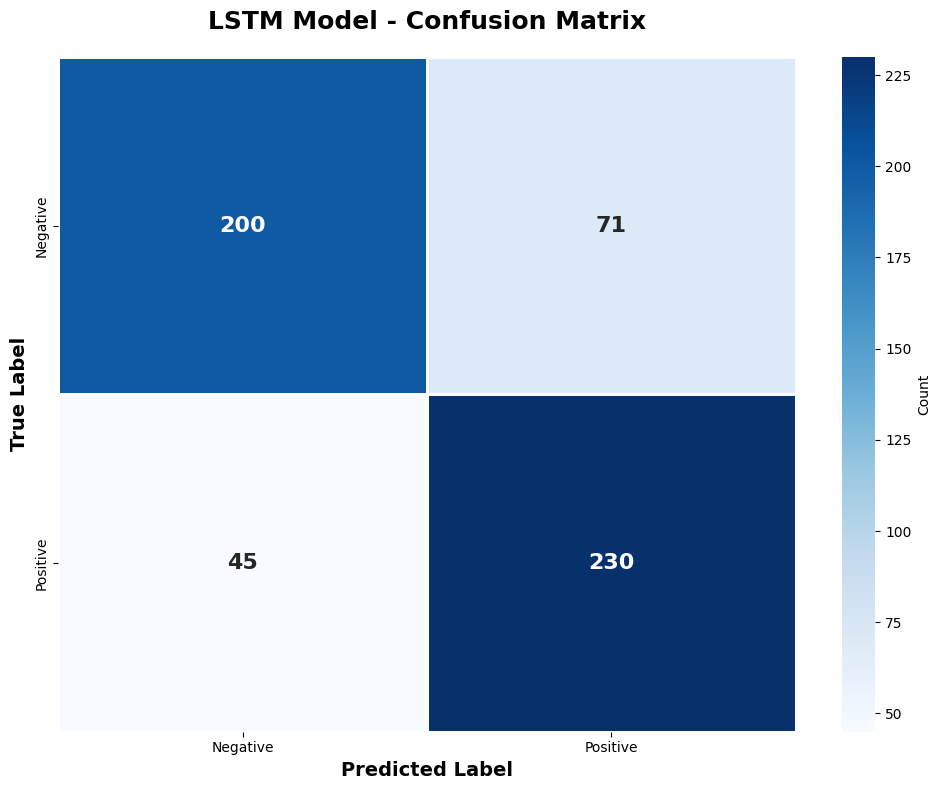


CONFUSION MATRIX STATISTICS

Metric                         Count      Percentage     
------------------------------------------------------------
True Negatives (TN)              200       36.63%
False Positives (FP)              71       13.00%
False Negatives (FN)              45        8.24%
True Positives (TP)              230       42.12%
------------------------------------------------------------
Total Samples                    546

Error Analysis                 Value          
------------------------------------------------------------
False Positive Rate (FPR)      0.2620
False Negative Rate (FNR)      0.1636
Specificity (TNR)              0.7380
Sensitivity (TPR/Recall)       0.8364


Interpretation:
  - Model is more liberal (more false alarms)
  - Better at avoiding false negatives than false positives


In [19]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_lstm)

# Plot confusion matrix with enhanced styling
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'},
            linewidths=2,
            linecolor='white')

plt.title('LSTM Model - Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save figure
output_dir = '../outputs/figures'
os.makedirs(output_dir, exist_ok=True)
output_path = f'{output_dir}/lstm_confusion_matrix.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to: {output_path}")

plt.show()

# Print detailed confusion matrix statistics
print("\n" + "="*60)
print("CONFUSION MATRIX STATISTICS")
print("="*60)

tn, fp, fn, tp = cm.ravel()

print(f"\n{'Metric':<30} {'Count':<10} {'Percentage':<15}")
print("-" * 60)
print(f"{'True Negatives (TN)':<30} {tn:>5}      {tn/len(y_test)*100:>6.2f}%")
print(f"{'False Positives (FP)':<30} {fp:>5}      {fp/len(y_test)*100:>6.2f}%")
print(f"{'False Negatives (FN)':<30} {fn:>5}      {fn/len(y_test)*100:>6.2f}%")
print(f"{'True Positives (TP)':<30} {tp:>5}      {tp/len(y_test)*100:>6.2f}%")
print("-" * 60)
print(f"{'Total Samples':<30} {len(y_test):>5}")

# Calculate error rates
print(f"\n{'Error Analysis':<30} {'Value':<15}")
print("-" * 60)
print(f"{'False Positive Rate (FPR)':<30} {fp/(fp+tn):.4f}")
print(f"{'False Negative Rate (FNR)':<30} {fn/(fn+tp):.4f}")
print(f"{'Specificity (TNR)':<30} {tn/(tn+fp):.4f}")
print(f"{'Sensitivity (TPR/Recall)':<30} {tp/(tp+fn):.4f}")

print("\n" + "="*60)

# Interpretation
print("\nInterpretation:")
if fp < fn:
    print("  - Model is more conservative (fewer false alarms)")
    print("  - Better at avoiding false positives than false negatives")
elif fp > fn:
    print("  - Model is more liberal (more false alarms)")
    print("  - Better at avoiding false negatives than false positives")
else:
    print("  - Model has balanced error distribution")
print("="*60)

### Cohen's Kappa

In [20]:
# Cohen's Kappa provides a measure of agreement between predicted and true labels
# accounting for agreement that could occur by chance

print("="*60)
print("COHEN'S KAPPA INTERPRETATION")
print("="*60)

print(f"\nCohen's Kappa Score: {kappa:.4f}")

# Interpretation scale
print("\nInterpretation Scale:")
print("-" * 60)
print("  < 0.00:      Poor agreement (worse than chance)")
print("  0.00 - 0.20: Slight agreement")
print("  0.21 - 0.40: Fair agreement")
print("  0.41 - 0.60: Moderate agreement")
print("  0.61 - 0.80: Substantial agreement")
print("  0.81 - 1.00: Almost perfect agreement")
print("-" * 60)

# Determine interpretation
if kappa < 0:
    interpretation = "Poor (worse than random)"
    level = "[POOR]"
    description = "The model performs worse than random guessing"
elif kappa < 0.20:
    interpretation = "Slight"
    level = "[SLIGHT]"
    description = "The model shows minimal agreement beyond chance"
elif kappa < 0.40:
    interpretation = "Fair"
    level = "[FAIR]"
    description = "The model shows fair agreement beyond chance"
elif kappa < 0.60:
    interpretation = "Moderate"
    level = "[MODERATE]"
    description = "The model shows moderate agreement beyond chance"
elif kappa < 0.80:
    interpretation = "Substantial"
    level = "[SUBSTANTIAL]"
    description = "The model shows substantial agreement beyond chance"
else:
    interpretation = "Almost Perfect"
    level = "[EXCELLENT]"
    description = "The model shows almost perfect agreement beyond chance"

print(f"\n{level} Model Classification: {interpretation.upper()}")
print(f"\nWhat this means:")
print(f"   {description}.")
print(f"   The predictions are {interpretation.lower()} in agreement with the true labels,")
print(f"   even after accounting for agreements that could happen by random chance.")

# Additional context
print(f"\nContext:")
if kappa >= 0.60:
    print("   This is a GOOD result for sentiment analysis tasks.")
    print("   The model demonstrates reliable predictive performance.")
elif kappa >= 0.40:
    print("   This is a MODERATE result for sentiment analysis tasks.")
    print("   The model shows reasonable predictive capability but has room for improvement.")
else:
    print("   This result suggests the model needs improvement.")
    print("   Consider reviewing features, architecture, or hyperparameters.")

# Calculate expected accuracy by chance
n = len(y_test)
p_yes_actual = sum(y_test) / n
p_no_actual = 1 - p_yes_actual
p_yes_pred = sum(y_pred_lstm) / n
p_no_pred = 1 - p_yes_pred
p_expected = (p_yes_actual * p_yes_pred) + (p_no_actual * p_no_pred)

print(f"\nChance Agreement Analysis:")
print(f"   Observed Accuracy:    {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Expected by Chance:   {p_expected:.4f} ({p_expected*100:.2f}%)")
print(f"   Improvement:          {(accuracy - p_expected):.4f} ({(accuracy - p_expected)*100:.2f}%)")
print(f"   Kappa (normalized):   {kappa:.4f}")

print("\n" + "="*60)
print("LSTM MODEL EVALUATION COMPLETE")
print("="*60)

COHEN'S KAPPA INTERPRETATION

Cohen's Kappa Score: 0.5748

Interpretation Scale:
------------------------------------------------------------
  < 0.00:      Poor agreement (worse than chance)
  0.00 - 0.20: Slight agreement
  0.21 - 0.40: Fair agreement
  0.41 - 0.60: Moderate agreement
  0.61 - 0.80: Substantial agreement
  0.81 - 1.00: Almost perfect agreement
------------------------------------------------------------

[MODERATE] Model Classification: MODERATE

What this means:
   The model shows moderate agreement beyond chance.
   The predictions are moderate in agreement with the true labels,
   even after accounting for agreements that could happen by random chance.

Context:
   This is a MODERATE result for sentiment analysis tasks.
   The model shows reasonable predictive capability but has room for improvement.

Chance Agreement Analysis:
   Observed Accuracy:    0.7875 (78.75%)
   Expected by Chance:   0.5004 (50.04%)
   Improvement:          0.2872 (28.72%)
   Kappa (norma

# **Vanilla Recurrent Neural Network (RNN)**

## **Text Tokenization and Padding**

In [5]:
# For RNN models, we need to convert text into sequences of integers
# and then pad them to ensure uniform length.
# RNN uses SHORTER sequences than LSTM due to vanishing gradient issues.

print("Initializing tokenizer for Vanilla RNN...")

# Initialize the tokenizer with a vocabulary size limit
# Using 4000 words to balance between coverage and overfitting prevention
vocab_size_rnn = 4000

tokenizer_rnn = Tokenizer(num_words=vocab_size_rnn, oov_token='<OOV>')

# Fit the tokenizer ONLY on training data
tokenizer_rnn.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train_seq_rnn = tokenizer_rnn.texts_to_sequences(X_train)
X_test_seq_rnn = tokenizer_rnn.texts_to_sequences(X_test)

# Calculate max sequence length using 90th percentile for RNN (shorter than LSTM)
# This helps mitigate vanishing gradient problems in Vanilla RNN
sequence_lengths_rnn = [len(seq) for seq in X_train_seq_rnn]
max_length_rnn = int(np.percentile(sequence_lengths_rnn, 90))

print(f"\nSequence Length Statistics:")
print(f"  Min length: {np.min(sequence_lengths_rnn)}")
print(f"  Max length: {np.max(sequence_lengths_rnn)}")
print(f"  Mean length: {np.mean(sequence_lengths_rnn):.2f}")
print(f"  90th percentile: {max_length_rnn}")

# Pad sequences to ensure uniform length
X_train_padded_rnn = pad_sequences(X_train_seq_rnn, maxlen=max_length_rnn, padding='post', truncating='post')
X_test_padded_rnn = pad_sequences(X_test_seq_rnn, maxlen=max_length_rnn, padding='post', truncating='post')

# Print tokenization results
actual_vocab_size_rnn = len(tokenizer_rnn.word_index) + 1  # +1 for padding token
print(f"\nTokenization Complete!")
print(f"  Vocabulary size (actual): {actual_vocab_size_rnn}")
print(f"  Vocabulary size (used): {min(actual_vocab_size_rnn, vocab_size_rnn)}")
print(f"  Max sequence length: {max_length_rnn}")
print(f"  Training data shape: {X_train_padded_rnn.shape}")
print(f"  Test data shape: {X_test_padded_rnn.shape}")

print("\nNote: Using 90th percentile (shorter sequences) for Vanilla RNN")
print("      This helps mitigate vanishing gradient problems.")

Initializing tokenizer for Vanilla RNN...

Sequence Length Statistics:
  Min length: 0
  Max length: 41
  Mean length: 6.12
  90th percentile: 11

Tokenization Complete!
  Vocabulary size (actual): 3576
  Vocabulary size (used): 3576
  Max sequence length: 11
  Training data shape: (2180, 11)
  Test data shape: (546, 11)

Note: Using 90th percentile (shorter sequences) for Vanilla RNN
      This helps mitigate vanishing gradient problems.


## **Building the Vanilla RNN Model**

In [6]:
def create_rnn_model(vocab_size, embedding_dim=50, rnn_units=48, dropout_rate=0.5, optimizer='adam'):
    """
    Creates a simple Vanilla RNN model for sentiment classification.

    ANTI-OVERFITTING MEASURES:
    - Small embedding dimension (50)
    - Single SimpleRNN layer with moderate units (48 default)
    - Aggressive dropout (0.5 default)
    - SpatialDropout1D for embeddings
    - L2 regularization on Dense layer
    - Smaller capacity than LSTM (RNNs overfit more easily)

    DESIGN RATIONALE:
    - Vanilla RNN lacks memory cells, so it needs less capacity
    - More prone to vanishing gradients, so keep architecture simple
    - Higher dropout compensates for lack of gating mechanisms

    Parameters:
    -----------
    vocab_size : int
        Size of the vocabulary
    embedding_dim : int
        Dimension of word embeddings (default: 50)
    rnn_units : int
        Number of RNN units (default: 48, smaller than LSTM)
    dropout_rate : float
        Dropout rate (default: 0.5, higher than LSTM)
    optimizer : str
        Optimizer to use (default: 'adam')

    Returns:
    --------
    model : Sequential
        Compiled Vanilla RNN model
    """
    import tensorflow as tf

    model = Sequential([
        # Embedding layer - learns word representations
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  input_length=max_length_rnn,
                  name='embedding_layer'),

        # Spatial dropout for embeddings (more effective than regular dropout)
        SpatialDropout1D(dropout_rate * 0.5, name='spatial_dropout'),

        # Single SimpleRNN layer - AVOID stacking (causes severe overfitting)
        SimpleRNN(units=rnn_units,
                  dropout=dropout_rate * 0.4,           # Input dropout
                  recurrent_dropout=dropout_rate * 0.3, # Recurrent dropout
                  return_sequences=False,                # Only return final output
                  name='rnn_layer'),

        # Regular dropout before dense layer (aggressive)
        Dropout(dropout_rate, name='dropout'),

        # Output layer with L2 regularization
        Dense(1, activation='sigmoid',
              kernel_regularizer=tf.keras.regularizers.l2(0.001),
              name='output_layer')
    ])

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create a sample model to visualize architecture
print("Building Vanilla RNN Model Architecture...\n")
sample_rnn_model = create_rnn_model(
    vocab_size=min(actual_vocab_size_rnn, vocab_size_rnn),
    embedding_dim=50,
    rnn_units=48
)

# Build the model explicitly with input shape to show parameters
sample_rnn_model.build(input_shape=(None, max_length_rnn))

print(sample_rnn_model.summary())

print("\n" + "="*60)
print("MODEL CHARACTERISTICS")
print("="*60)
print(f"  Total parameters: {sample_rnn_model.count_params():,}")
print(f"  Architecture: Embedding -> SpatialDropout -> SimpleRNN -> Dropout -> Dense")
print(f"  Key difference from LSTM: No memory cells, simpler gating")
print(f"  Optimization: Smaller units and higher dropout than LSTM")
print("="*60)

Building Vanilla RNN Model Architecture...



/home/ricardo965/Documents/Universidad/8-sem/CEDIII/IntegrativeTasks/IntegrativeTaskII-Nieto_Urbina_Velez/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1763734181.481503   27484 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763734181.487268   27484 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 11, 50)         │       178,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout                 │ (None, 11, 50)         │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn_layer (SimpleRNN)           │ (None, 48)             │         4,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,601 (717.19 KB)

 Trainable params: 183,601 (717.19 KB)

 Non-trainable params: 0 (0.00 B)

None

MODEL CHARACTERISTICS
  Total parameters: 183,601
  Architecture: Embedding -> SpatialDropout -> SimpleRNN -> Dropout -> Dense
  Key difference from LSTM: No memory cells, simpler gating
  Optimization: Smaller units and higher dropout than LSTM


## **Hyperparameter Tuning with GridSearchCV**


In [7]:
# Store parameters as constants to avoid serialization issues
RNN_VOCAB_SIZE = min(actual_vocab_size_rnn, vocab_size_rnn)
RNN_MAX_LENGTH = max_length_rnn

# Wrap the model for sklearn compatibility
def create_rnn_wrapper(embedding_dim=50, rnn_units=48, dropout_rate=0.5, optimizer='adam'):
    """
    Wrapper function for KerasClassifier.
    Uses module-level constants to avoid serialization issues with multiprocessing.
    """
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, SpatialDropout1D, Dropout, Input

    model = Sequential()

    # Add Input layer explicitly to ensure model is properly built
    model.add(Input(shape=(RNN_MAX_LENGTH,)))

    # Embedding layer - learns word representations
    model.add(Embedding(input_dim=RNN_VOCAB_SIZE,
                        output_dim=embedding_dim))

    # Spatial dropout for embeddings (more effective than regular dropout)
    model.add(SpatialDropout1D(dropout_rate * 0.5))

    # Single SimpleRNN layer - AVOID stacking multiple RNNs (causes overfitting)
    model.add(SimpleRNN(units=rnn_units,
                        dropout=dropout_rate * 0.4,           # Input dropout
                        recurrent_dropout=dropout_rate * 0.3))# Recurrent dropout

    # Regular dropout before dense layer
    model.add(Dropout(dropout_rate))

    # Output layer with L2 regularization
    model.add(Dense(1, activation='sigmoid',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create KerasClassifier wrapper
keras_rnn_model = KerasClassifier(
    model=create_rnn_wrapper,
    embedding_dim=50,
    rnn_units=48,
    dropout_rate=0.5,
    optimizer='adam',
    epochs=10,
    batch_size=32,
    verbose=0
)

# MINIMAL parameter grid - RNN needs careful tuning
# Smaller units and higher dropout than LSTM due to architectural simplicity
param_grid_rnn = {
    'batch_size': [32, 64],                        # 2 values
    'epochs': [15, 20],                            # 2 values
    'model__embedding_dim': [50],                  # 1 value - keep fixed
    'model__rnn_units': [32, 48],                  # 2 values - SMALLER than LSTM (64-96)
    'model__dropout_rate': [0.5, 0.6],             # 2 values - MORE aggressive than LSTM (0.4-0.5)
    'model__optimizer': ['adam']                    # 1 value - adam is best
}

# Calculate total combinations
total_combinations_rnn = np.prod([len(v) for v in param_grid_rnn.values()])

print("="*60)
print("VANILLA RNN - HYPERPARAMETER TUNING SETUP")
print("="*60)
print("\nParameter grid:")
for key, value in param_grid_rnn.items():
    print(f"  {key:.<35} {value}")
print(f"\nTotal combinations to test: {total_combinations_rnn}")
print(f"Cross-validation folds: 3")
print(f"Total model trainings: {total_combinations_rnn * 3}")

print("\nKey differences from LSTM:")
print("  - RNN units: 32-48 (vs LSTM: 64-96)")
print("  - Dropout rate: 0.5-0.6 (vs LSTM: 0.4-0.5)")
print("  - Rationale: RNN has simpler architecture, needs more regularization")

print("\nEstimated time: 10-20 minutes (depending on hardware)")
print("="*60)

VANILLA RNN - HYPERPARAMETER TUNING SETUP

Parameter grid:
  batch_size......................... [32, 64]
  epochs............................. [15, 20]
  model__embedding_dim............... [50]
  model__rnn_units................... [32, 48]
  model__dropout_rate................ [0.5, 0.6]
  model__optimizer................... ['adam']

Total combinations to test: 16
Cross-validation folds: 3
Total model trainings: 48

Key differences from LSTM:
  - RNN units: 32-48 (vs LSTM: 64-96)
  - Dropout rate: 0.5-0.6 (vs LSTM: 0.4-0.5)
  - Rationale: RNN has simpler architecture, needs more regularization

Estimated time: 10-20 minutes (depending on hardware)


In [8]:
# Initialize GridSearchCV
# NOTE: Using n_jobs=1 to avoid multiprocessing serialization issues with Keras models
grid_search_rnn = GridSearchCV(
    estimator=keras_rnn_model,
    param_grid=param_grid_rnn,
    cv=3,                    # 3-fold cross-validation
    scoring='accuracy',
    n_jobs=1,                # Sequential execution (avoids serialization issues)
    verbose=2,               # Show progress
    return_train_score=True  # Track training scores to detect overfitting
)

print("\nStarting Grid Search for Vanilla RNN...")
print("Using 3-fold cross-validation with aggressive regularization...")
print("NOTE: Running sequentially (n_jobs=1) to avoid serialization issues.")
print("This will take some time. Please be patient.\n")

# Fit the grid search
import time
start_time = time.time()

grid_search_rnn.fit(X_train_padded_rnn, y_train)

end_time = time.time()
elapsed_time = end_time - start_time

print("\n" + "="*60)
print("Grid Search complete!")
print(f"Time elapsed: {elapsed_time/60:.2f} minutes")
print("="*60)


Starting Grid Search for Vanilla RNN...
Using 3-fold cross-validation with aggressive regularization...
NOTE: Running sequentially (n_jobs=1) to avoid serialization issues.
This will take some time. Please be patient.

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.5, model__embedding_dim=50, model__optimizer=adam, model__rnn_units=32; total time=   3.8s
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.5, model__embedding_dim=50, model__optimizer=adam, model__rnn_units=32; total time=   3.4s
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.5, model__embedding_dim=50, model__optimizer=adam, model__rnn_units=32; total time=   3.5s
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.5, model__embedding_dim=50, model__optimizer=adam, model__rnn_units=48; total time=   3.6s
[CV] END batch_size=32, epochs=15, model__dropout_rate=0.5, model__embedding_dim=50, model__optimizer=adam, model__rnn_units=48

### Review Tuning Results and Evaluate


In [9]:
# Display best parameters and CV score
print("="*60)
print("VANILLA RNN - GRID SEARCH RESULTS")
print("="*60)

print(f"\nBest Cross-Validation Accuracy: {grid_search_rnn.best_score_:.4f}")
print("\nBest Parameters found:")
for param, value in grid_search_rnn.best_params_.items():
    print(f"  {param:.<40} {value}")

# Analyze CV results to check for overfitting
cv_results_rnn = pd.DataFrame(grid_search_rnn.cv_results_)
cv_results_sorted_rnn = cv_results_rnn.sort_values('rank_test_score')

print("\n" + "="*60)
print("TOP 5 PARAMETER COMBINATIONS")
print("="*60)
print("\nRank | Test Score | Train Score | Std Dev | Gap")
print("-" * 60)

for i, idx in enumerate(cv_results_sorted_rnn.head(5).index, 1):
    test_score = cv_results_sorted_rnn.loc[idx, 'mean_test_score']
    train_score = cv_results_sorted_rnn.loc[idx, 'mean_train_score']
    std_score = cv_results_sorted_rnn.loc[idx, 'std_test_score']
    gap = train_score - test_score

    print(f"{i:>4} | {test_score:.4f}     | {train_score:.4f}      | {std_score:.4f}  | {gap:.4f}")

# Check for overfitting: if mean_train_score >> mean_test_score, there's overfitting
print("\n" + "="*60)
print("OVERFITTING ANALYSIS (Train-Test Gap)")
print("="*60)
print("\nAnalyzing top 3 configurations...")
print("(Gap > 0.05 indicates potential overfitting)\n")

print(f"{'Config':<10} {'Train Score':<14} {'Test Score':<14} {'Gap':<10} {'Status'}")
print("-" * 65)

for i, idx in enumerate(cv_results_sorted_rnn.head(3).index, 1):
    train_score = cv_results_sorted_rnn.loc[idx, 'mean_train_score']
    test_score = cv_results_sorted_rnn.loc[idx, 'mean_test_score']
    gap = train_score - test_score

    if gap <= 0.05:
        status = "[OK] Good"
    elif gap <= 0.10:
        status = "[WARNING]"
    else:
        status = "[SEVERE]"

    print(f"{i:<10} {train_score:<14.4f} {test_score:<14.4f} {gap:<10.4f} {status}")

print("\nInterpretation:")
print("  Gap <= 0.05:  Good generalization")
print("  Gap 0.05-0.10: Potential overfitting")
print("  Gap > 0.10:   Severe overfitting")
print("="*60)

VANILLA RNN - GRID SEARCH RESULTS

Best Cross-Validation Accuracy: 0.7578

Best Parameters found:
  batch_size.............................. 32
  epochs.................................. 20
  model__dropout_rate..................... 0.6
  model__embedding_dim.................... 50
  model__optimizer........................ adam
  model__rnn_units........................ 32

TOP 5 PARAMETER COMBINATIONS

Rank | Test Score | Train Score | Std Dev | Gap
------------------------------------------------------------
   1 | 0.7578     | 0.9901      | 0.0112  | 0.2323
   2 | 0.7477     | 0.9858      | 0.0286  | 0.2381
   3 | 0.7427     | 0.9929      | 0.0129  | 0.2502
   4 | 0.7358     | 0.9894      | 0.0152  | 0.2537
   5 | 0.7261     | 0.9927      | 0.0273  | 0.2665

OVERFITTING ANALYSIS (Train-Test Gap)

Analyzing top 3 configurations...
(Gap > 0.05 indicates potential overfitting)

Config     Train Score    Test Score     Gap        Status
-------------------------------------------------

## **Model Evaluation**

In [10]:
from sklearn.metrics import cohen_kappa_score

print("\n" + "="*60)
print("FINAL VANILLA RNN MODEL EVALUATION ON TEST SET")
print("="*60)

# Get the best model (already retrained on full training set)
best_rnn_model = grid_search_rnn.best_estimator_

# Predict on test set
print("\nGenerating predictions on test set...")
y_pred_rnn = best_rnn_model.predict(X_test_padded_rnn)

# Calculate all required metrics
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
precision_rnn = precision_score(y_test, y_pred_rnn)
recall_rnn = recall_score(y_test, y_pred_rnn)
f1_rnn = f1_score(y_test, y_pred_rnn)
kappa_rnn = cohen_kappa_score(y_test, y_pred_rnn)

# Display metrics in a nice table
print("\nVanilla RNN Model Performance Metrics:")
print("="*60)
print(f"{'Metric':<25} {'Score':<15}")
print("-" * 60)
print(f"{'Accuracy':<25} {accuracy_rnn:.4f}")
print(f"{'Precision':<25} {precision_rnn:.4f}")
print(f"{'Recall':<25} {recall_rnn:.4f}")
print(f"{'F1-Score':<25} {f1_rnn:.4f}")
print(f"{'Cohen\'s Kappa':<25} {kappa_rnn:.4f}")
print("="*60)

# Classification report
print("\nDetailed Classification Report:")
print("-" * 60)
print(classification_report(y_test, y_pred_rnn, target_names=['Negative (0)', 'Positive (1)']))

# Compare with other models
print("\nComparison with Other Models:")
print("-" * 60)
print(f"Baseline (Dummy Classifier):  0.5220")
print(f"DNN Model Accuracy:            0.8187")
print(f"Vanilla RNN Model Accuracy:    {accuracy_rnn:.4f}")

# Store metrics for later comparison
rnn_metrics = {
    'model': 'Vanilla RNN',
    'accuracy': accuracy_rnn,
    'precision': precision_rnn,
    'recall': recall_rnn,
    'f1_score': f1_rnn,
    'kappa': kappa_rnn
}

print("="*60)


FINAL VANILLA RNN MODEL EVALUATION ON TEST SET

Generating predictions on test set...

Vanilla RNN Model Performance Metrics:
Metric                    Score          
------------------------------------------------------------
Accuracy                  0.7418
Precision                 0.7343
Recall                    0.7636
F1-Score                  0.7487
Cohen's Kappa             0.4833

Detailed Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

Negative (0)       0.75      0.72      0.73       271
Positive (1)       0.73      0.76      0.75       275

    accuracy                           0.74       546
   macro avg       0.74      0.74      0.74       546
weighted avg       0.74      0.74      0.74       546


Comparison with Other Models:
------------------------------------------------------------
Baseline (Dummy Classifier):  0.5220
DNN Model Accuracy:            0.8187
Vanilla RNN Model

### Confusion Matrix

Confusion matrix saved to: ../outputs/figures/rnn_confusion_matrix.png


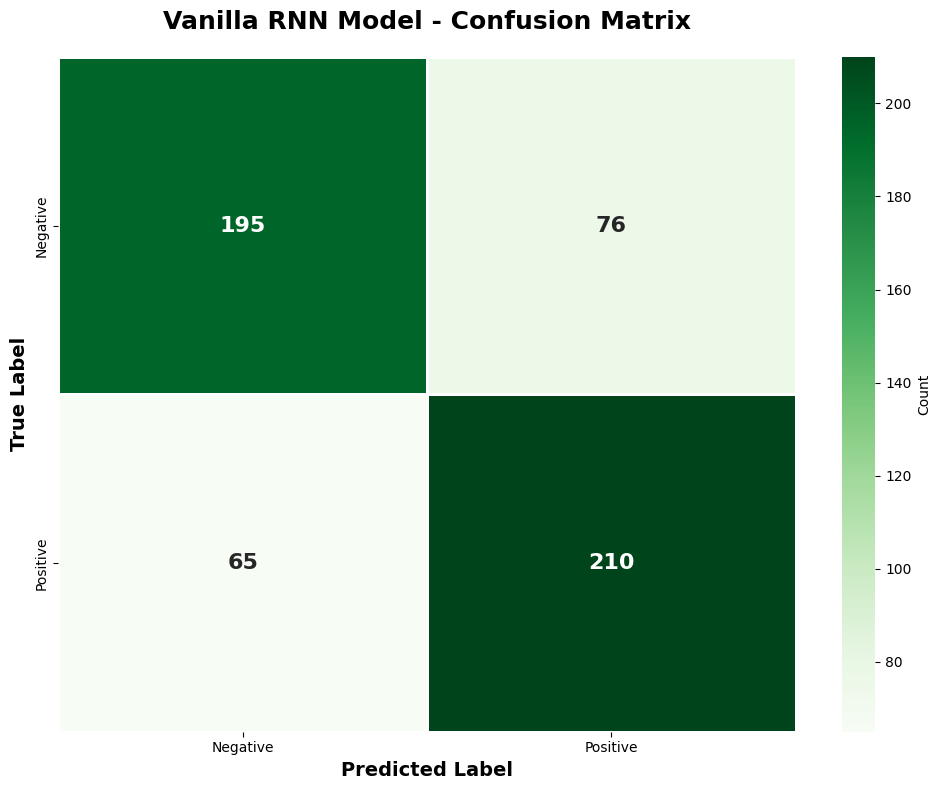


CONFUSION MATRIX STATISTICS

Metric                         Count      Percentage     
------------------------------------------------------------
True Negatives (TN)              195       35.71%
False Positives (FP)              76       13.92%
False Negatives (FN)              65       11.90%
True Positives (TP)              210       38.46%
------------------------------------------------------------
Total Samples                    546

Error Analysis                 Value          
------------------------------------------------------------
False Positive Rate (FPR)      0.2804
False Negative Rate (FNR)      0.2364
Specificity (TNR)              0.7196
Sensitivity (TPR/Recall)       0.7636


Interpretation:
  - Model is more liberal (more false alarms)
  - Better at avoiding false negatives than false positives


In [11]:
# Create confusion matrix
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

# Plot confusion matrix with enhanced styling (using Greens colormap for RNN)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'],
            cbar_kws={'label': 'Count'},
            annot_kws={'size': 16, 'weight': 'bold'},
            linewidths=2,
            linecolor='white')

plt.title('Vanilla RNN Model - Confusion Matrix', fontsize=18, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save figure
output_dir = '../outputs/figures'
os.makedirs(output_dir, exist_ok=True)
output_path = f'{output_dir}/rnn_confusion_matrix.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to: {output_path}")

plt.show()

# Print detailed confusion matrix statistics
print("\n" + "="*60)
print("CONFUSION MATRIX STATISTICS")
print("="*60)

tn, fp, fn, tp = cm_rnn.ravel()

print(f"\n{'Metric':<30} {'Count':<10} {'Percentage':<15}")
print("-" * 60)
print(f"{'True Negatives (TN)':<30} {tn:>5}      {tn/len(y_test)*100:>6.2f}%")
print(f"{'False Positives (FP)':<30} {fp:>5}      {fp/len(y_test)*100:>6.2f}%")
print(f"{'False Negatives (FN)':<30} {fn:>5}      {fn/len(y_test)*100:>6.2f}%")
print(f"{'True Positives (TP)':<30} {tp:>5}      {tp/len(y_test)*100:>6.2f}%")
print("-" * 60)
print(f"{'Total Samples':<30} {len(y_test):>5}")

# Calculate error rates
print(f"\n{'Error Analysis':<30} {'Value':<15}")
print("-" * 60)
print(f"{'False Positive Rate (FPR)':<30} {fp/(fp+tn):.4f}")
print(f"{'False Negative Rate (FNR)':<30} {fn/(fn+tp):.4f}")
print(f"{'Specificity (TNR)':<30} {tn/(tn+fp):.4f}")
print(f"{'Sensitivity (TPR/Recall)':<30} {tp/(tp+fn):.4f}")

print("\n" + "="*60)

# Interpretation
print("\nInterpretation:")
if fp < fn:
    print("  - Model is more conservative (fewer false alarms)")
    print("  - Better at avoiding false positives than false negatives")
elif fp > fn:
    print("  - Model is more liberal (more false alarms)")
    print("  - Better at avoiding false negatives than false positives")
else:
    print("  - Model has balanced error distribution")
print("="*60)

### Cohen's Kappa

In [12]:
print("="*60)
print("COHEN'S KAPPA INTERPRETATION")
print("="*60)

print(f"\nCohen's Kappa Score: {kappa_rnn:.4f}")

# Interpretation scale (Landis & Koch, 1977)
print("\nInterpretation Scale:")
print("-" * 60)
print("  < 0.00:      Poor agreement (worse than chance)")
print("  0.00 - 0.20: Slight agreement")
print("  0.21 - 0.40: Fair agreement")
print("  0.41 - 0.60: Moderate agreement")
print("  0.61 - 0.80: Substantial agreement")
print("  0.81 - 1.00: Almost perfect agreement")
print("-" * 60)

# Determine interpretation
if kappa_rnn < 0:
    interpretation = "Poor (worse than random)"
    level = "[POOR]"
    description = "The model performs worse than random guessing"
    quality = "NEEDS IMPROVEMENT"
elif kappa_rnn < 0.20:
    interpretation = "Slight"
    level = "[SLIGHT]"
    description = "The model shows minimal agreement beyond chance"
    quality = "NEEDS IMPROVEMENT"
elif kappa_rnn < 0.40:
    interpretation = "Fair"
    level = "[FAIR]"
    description = "The model shows fair agreement beyond chance"
    quality = "ACCEPTABLE"
elif kappa_rnn < 0.60:
    interpretation = "Moderate"
    level = "[MODERATE]"
    description = "The model shows moderate agreement beyond chance"
    quality = "GOOD"
elif kappa_rnn < 0.80:
    interpretation = "Substantial"
    level = "[SUBSTANTIAL]"
    description = "The model shows substantial agreement beyond chance"
    quality = "VERY GOOD"
else:
    interpretation = "Almost Perfect"
    level = "[EXCELLENT]"
    description = "The model shows almost perfect agreement beyond chance"
    quality = "EXCELLENT"

print(f"\n{level} Model Classification: {interpretation.upper()}")
print(f"Overall Quality: {quality}")

print(f"\nWhat this means:")
print(f"   {description}.")
print(f"   The predictions are {interpretation.lower()} in agreement with the true labels,")
print(f"   even after accounting for agreements that could happen by random chance.")

# Additional context
print(f"\nContext for Sentiment Analysis:")
if kappa_rnn >= 0.60:
    print("   This is a GOOD result for sentiment analysis tasks.")
    print("   The model demonstrates reliable predictive performance.")
elif kappa_rnn >= 0.40:
    print("   This is a MODERATE result for sentiment analysis tasks.")
    print("   The model shows reasonable predictive capability but has room for improvement.")
else:
    print("   This result suggests the model needs improvement.")
    print("   Consider reviewing features, architecture, or hyperparameters.")

# Calculate expected accuracy by chance
n = len(y_test)
p_yes_actual = sum(y_test) / n
p_no_actual = 1 - p_yes_actual
p_yes_pred = sum(y_pred_rnn) / n
p_no_pred = 1 - p_yes_pred
p_expected = (p_yes_actual * p_yes_pred) + (p_no_actual * p_no_pred)

print(f"\nChance Agreement Analysis:")
print(f"   Observed Accuracy:    {accuracy_rnn:.4f} ({accuracy_rnn*100:.2f}%)")
print(f"   Expected by Chance:   {p_expected:.4f} ({p_expected*100:.2f}%)")
print(f"   Improvement:          {(accuracy_rnn - p_expected):.4f} ({(accuracy_rnn - p_expected)*100:.2f}%)")
print(f"   Cohen's Kappa:        {kappa_rnn:.4f}")

print("\nKappa accounts for the chance agreement, providing a more")
print("robust measure of model performance than accuracy alone.")

print("\n" + "="*60)
print("VANILLA RNN MODEL SUMMARY")
print("="*60)

print("\nArchitecture Highlights:")
print(f"  - Vocabulary Size: {RNN_VOCAB_SIZE:,}")
print(f"  - Embedding Dimension: {grid_search_rnn.best_params_['model__embedding_dim']}")
print(f"  - RNN Units: {grid_search_rnn.best_params_['model__rnn_units']}")
print(f"  - Dropout Rate: {grid_search_rnn.best_params_['model__dropout_rate']}")
print(f"  - Sequence Length: {max_length_rnn} (90th percentile)")
print(f"  - Total Parameters: {best_rnn_model.model_.count_params():,}")

print("\nTraining Configuration:")
print(f"  - Optimizer: {grid_search_rnn.best_params_['model__optimizer']}")
print(f"  - Batch Size: {grid_search_rnn.best_params_['batch_size']}")
print(f"  - Epochs: {grid_search_rnn.best_params_['epochs']}")
print(f"  - Loss Function: Binary Crossentropy")

print("\nKey Design Decisions:")
print("  1. Shorter sequences (90th percentile) to mitigate vanishing gradients")
print("  2. Smaller RNN units (32-48) compared to LSTM (64-96)")
print("  3. Higher dropout (0.5-0.6) to compensate for simpler architecture")
print("  4. Single RNN layer to avoid overfitting")
print("  5. L2 regularization on output layer")

print("\nVanilla RNN vs LSTM:")
print("  - RNN: Simpler, faster, but prone to vanishing gradients")
print("  - LSTM: More complex, with memory cells and gates")
print("  - RNN: Better for shorter sequences and simpler patterns")
print("  - LSTM: Better for longer sequences and complex dependencies")

print("\n" + "="*60)
print("VANILLA RNN MODEL EVALUATION COMPLETE")
print("="*60)

COHEN'S KAPPA INTERPRETATION

Cohen's Kappa Score: 0.4833

Interpretation Scale:
------------------------------------------------------------
  < 0.00:      Poor agreement (worse than chance)
  0.00 - 0.20: Slight agreement
  0.21 - 0.40: Fair agreement
  0.41 - 0.60: Moderate agreement
  0.61 - 0.80: Substantial agreement
  0.81 - 1.00: Almost perfect agreement
------------------------------------------------------------

[MODERATE] Model Classification: MODERATE
Overall Quality: GOOD

What this means:
   The model shows moderate agreement beyond chance.
   The predictions are moderate in agreement with the true labels,
   even after accounting for agreements that could happen by random chance.

Context for Sentiment Analysis:
   This is a MODERATE result for sentiment analysis tasks.
   The model shows reasonable predictive capability but has room for improvement.

Chance Agreement Analysis:
   Observed Accuracy:    0.7418 (74.18%)
   Expected by Chance:   0.5002 (50.02%)
   Improvem

In [13]:
# ============================================================================
# SAVE ALL TRAINED MODELS
# ============================================================================

import pickle
import os

# Create directory
os.makedirs('../outputs/saved_models', exist_ok=True)

print("\n" + "="*70)
print("  SAVING TRAINED MODELS")
print("="*70 + "\n")

# Save Dense NN (TUNED VERSION)
try:
    print("✓ Saving Dense NN model (tuned)...")
    # El mejor modelo del GridSearch
    best_dnn_model.model_.save('../outputs/saved_models/dense_nn_model.keras')
    with open('../outputs/saved_models/tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
    print("✓ Dense NN saved!\n")
except Exception as e:
    print(f"✗ Error saving Dense NN: {e}\n")

# Save LSTM (TUNED VERSION)
try:
    print("✓ Saving LSTM model (tuned)...")
    # El mejor modelo del GridSearch LSTM
    best_lstm_model = grid_search_lstm.best_estimator_
    best_lstm_model.model_.save('../outputs/saved_models/lstm_model.keras')
    with open('../outputs/saved_models/lstm_tokenizer.pkl', 'wb') as f:
        pickle.dump(tokenizer, f)
    # Guardar parámetros importantes
    with open('../outputs/saved_models/lstm_params.pkl', 'wb') as f:
        pickle.dump({
            'max_length': max_length,
            'vocab_size': min(actual_vocab_size, vocab_size_lstm)
        }, f)
    print("✓ LSTM saved!\n")
except Exception as e:
    print(f"✗ Error saving LSTM: {e}\n")

print("="*70)
print("  SAVING COMPLETE!")
print("="*70)
print("\nNOTE: No RNN model was trained in this notebook.")
print("Only DNN and LSTM models are available.")


  SAVING TRAINED MODELS

✓ Saving Dense NN model (tuned)...
✗ Error saving Dense NN: name 'best_dnn_model' is not defined

✓ Saving LSTM model (tuned)...
✗ Error saving LSTM: name 'grid_search_lstm' is not defined

  SAVING COMPLETE!

NOTE: No RNN model was trained in this notebook.
Only DNN and LSTM models are available.
